In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import os

In [2]:
data = json.load(open("./results/results_whitespaced.json"))
whitespaced_df = pd.json_normalize(data['benchmarks'])
data = json.load(open("./results/results_trimmed.json"))
trimmed_df = pd.json_normalize(data['benchmarks'])

df = pd.concat([trimmed_df.assign(source='trimmed'), whitespaced_df.assign(source='whitespaced')], sort=False)

df = df[df['name'].str.endswith('_mean')]
df['name'] = df['name'].str[:-18]


columns_to_keep = ['name', 'real_time', 'source']
df = df[columns_to_keep]

parser_pattern = r"(fpga::|simdjson::)"
df['parser'] = df['name'].str.extract(parser_pattern, expand=False)
df['name'] = df['name'].str.replace(parser_pattern, '', regex=True)
df['parser'] = df['parser'].str[:-2]

workload_pattern = r"(max_depth::|parse::|string_lengths::)"
df['workload'] = df['name'].str.extract(workload_pattern, expand=False)
df['name'] = df['name'].str.replace(workload_pattern, '', regex=True)
df['workload'] = df['workload'].str[:-2]
df = df.rename(columns={'name': 'dataset'})
df = df.rename(columns={'real_time': 'time (ns)'})

df['join_column'] = df['dataset'] + ' (' + df['source'] + ')'

In [3]:
folder_path = "trimmed"

# Create empty lists to store data
filenames = []
num_objects = []
num_arrays = []
avg_object_size = []
avg_array_size = []
num_strings = []

# Function to count objects in JSON data
def count_objects(data):
  if isinstance(data, dict):
    return 1 + sum(count_objects(item) for item in data.values())
  elif isinstance(data, list):
    return sum(count_objects(item) for item in data)
  else:
    return 0

# Function to count arrays in JSON data
def count_arrays(data):
  if isinstance(data, list):
    return 1 + sum(count_arrays(item) for item in data)
  elif isinstance(data, dict):
    return sum(count_arrays(item) for item in data.values())
  else:
    return 0

# Function to calculate object size
def object_size(obj):
  if isinstance(obj, dict):
    return len(obj) + sum(object_size(item) for item in obj.values())
  elif isinstance(obj, list):
    return sum(object_size(item) for item in obj)
  else:
    return 0

# Function to calculate array size
def array_size(arr):
  if isinstance(arr, list):
    return len(arr) + sum(array_size(item) for item in arr)
  elif isinstance(arr, dict):
      return sum(array_size(item) for item in arr.values())
  else:
    return 0

# Function to count strings
def count_strings(data):
  if isinstance(data, str):
    return 1
  elif isinstance(data, dict):
    return len(data) + sum(count_strings(item) for item in data.values())
  elif isinstance(data, list):
    return sum(count_strings(item) for item in data)
  else:
    return 0


# Loop through each JSON file in the folder
for filename in os.listdir(folder_path):
  # Get the full path of the file
  file_path = os.path.join(folder_path, filename)
  
  # Check if it's a JSON file
  if filename.endswith('.json'):
    try:
      # Open and read the JSON file
      with open(file_path, 'r') as f:
        data = json.load(f)
      
      # Count objects, arrays, and strings
      num_objects.append(count_objects(data))
      num_arrays.append(count_arrays(data))
      num_strings.append(count_strings(data))
      
      # Calculate average object and array size
      total_object_size = object_size(data)
      total_array_size = array_size(data)
      avg_object_size.append(total_object_size / num_objects[-1] if num_objects[-1] > 0 else 0)
      avg_array_size.append(total_array_size / num_arrays[-1] if num_arrays[-1] > 0 else 0)  # Avoid division by zero
      filenames.append(filename)
    except json.JSONDecodeError:
      print(f"Error parsing JSON file: {filename}")
      # Handle potential errors gracefully (e.g., skip or log the error)

# Create the DataFrame with column names
json_df = pd.DataFrame({
    'join_column': filenames,
    '#objects': num_objects,
    '#arrays': num_arrays,
    'avg_object_size': avg_object_size,
    'avg_array_size': avg_array_size,
    '#strings': num_strings,
})

# Create empty lists to store data
filenames = []
file_sizes = []

# Loop through each file in the folder
for filename in os.listdir(folder_path):
  # Get the full path of the file
  file_path = os.path.join(folder_path, filename)
  
  # Check if it's a regular file (avoid directories and special files)
  if os.path.isfile(file_path):
    # Get the file size in bytes
    file_size = os.path.getsize(file_path)
    # Append filename and size to their respective lists
    filenames.append(filename)
    file_sizes.append(file_size)

# Create the DataFrame with column names
trimmed_df = pd.DataFrame({'join_column': filenames, 'trimmed_size (bytes)': file_sizes})

folder_path = "./whitespaced"

# Create empty lists to store data
filenames = []
file_sizes = []

# Loop through each file in the folder
for filename in os.listdir(folder_path):
  # Get the full path of the file
  file_path = os.path.join(folder_path, filename)
  
  # Check if it's a regular file (avoid directories and special files)
  if os.path.isfile(file_path):
    # Get the file size in bytes
    file_size = os.path.getsize(file_path)
    # Append filename and size to their respective lists
    filenames.append(filename)
    file_sizes.append(file_size)

# Create the DataFrame with column names
whitespeced_df = pd.DataFrame({'join_column': filenames, 'whitespaced_size (bytes)': file_sizes})

files_df = trimmed_df.merge(whitespeced_df, on='join_column', how='inner')
json_df = json_df.merge(files_df, on='join_column', how='inner')
json_df['join_column'] = json_df['join_column'].str[:-13]

trimmed_json_df = json_df.copy()
trimmed_json_df = trimmed_json_df[['join_column', 'trimmed_size (bytes)']]
trimmed_json_df['join_column'] = trimmed_json_df['join_column'] + ' (trimmed)'
trimmed_json_df = trimmed_json_df.rename(columns={'trimmed_size (bytes)': 'size (bytes)'})

whitespaced_json_df = json_df.copy()
whitespaced_json_df = whitespaced_json_df[['join_column', 'whitespaced_size (bytes)']]
whitespaced_json_df['join_column'] = whitespaced_json_df['join_column'] + ' (whitespaced)'
whitespaced_json_df = whitespaced_json_df.rename(columns={'whitespaced_size (bytes)': 'size (bytes)'})

sizes_df = pd.concat([trimmed_json_df, whitespaced_json_df]) 

df = df.merge(sizes_df, on='join_column', how='inner')
json_df = json_df.rename(columns={'join_column': 'dataset'})

df = df.drop(['join_column'], axis=1)

df['bandwidth'] = (df['size (bytes)'] / (df['time (ns)'] / 1000000000)) / 1000000

In [4]:
excluded_datasets = ['mesh.pretty', 'google_maps_api_response', 'twitter_timeline', 'mesh', 'twitter', 'github_events', 'semanticscholar-corpus', 'numbers', 'twitter_api_response', 'instruments']

json_df = json_df[~json_df['dataset'].isin(excluded_datasets)]
json_df = json_df.reset_index(drop=True)
json_df['dataset'] = json_df['dataset'].replace('refsnp-unsupported35000', 'refsnp')

df = df[~df['dataset'].isin(excluded_datasets)]
df = df.reset_index(drop=True)
df['dataset'] = df['dataset'].replace('refsnp-unsupported35000', 'refsnp')

df_backup = df.copy()
#print(json_df.to_latex(index=False))

In [61]:
json_df

,dataset,#objects,#arrays,avg_object_size,avg_array_size,#strings,trimmed_size (bytes),whitespaced_size (bytes)
0,refsnp,1038083,485759,3.722263,1.435628,6901564,103990944,156529806
1,repeat,101,1,2.019802,100.000000,407,2953,4963
2,update-center,1896,1937,7.763186,1.037171,27615,568438,705508
3,apache_builds,884,3,2.997738,293.333333,5294,101695,124575
4,gsoc-2018,3793,0,4.998682,0.000000,34128,3081457,3187633
5,tree-pretty,115,84,8.295652,0.500000,1752,18066,33714
6,random,4001,1001,4.999750,3.996004,39007,418998,637008
7,marine_ik,9680,28377,3.943492,8.639356,283449,2678035,7836095
8,canada,4,56045,2.000000,2.982782,111138,2535721,5434673
9,citm_catalog,10937,10451,2.365274,1.139412,42259,607598,1182882


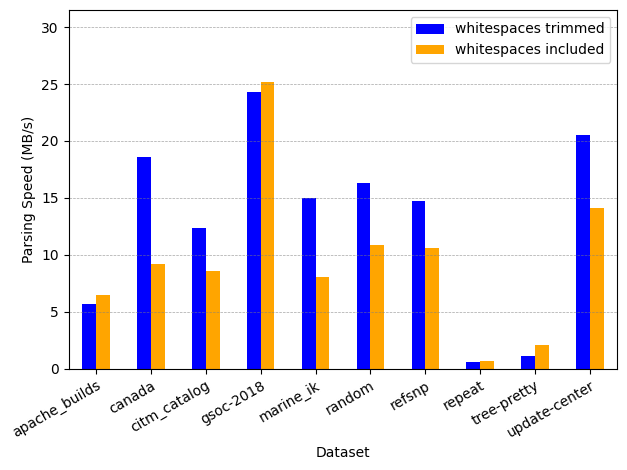

source,trimmed,whitespaced
dataset,,
apache_builds,5.684580,6.518735
canada,18.605186,9.201365
citm_catalog,12.398813,8.591813
gsoc-2018,24.285550,25.139654
marine_ik,14.991225,8.030486
random,16.296592,10.904200
refsnp,14.703118,10.588610
repeat,0.579117,0.663044
tree-pretty,1.081803,2.050188


In [70]:
df = df_backup.copy()
#df = df[df['source'] == 'trimmed']
df = df[df['workload'] == 'string_lengths']
df = df[df['parser'] == 'fpga']

# Define colors for the two parsers
colors = ['blue', 'orange']

# Group data by "dataset" and calculate average bandwidth for each parser
grouped_data = df.groupby(['dataset', 'source'])['bandwidth'].mean().unstack()

# Create the bar chart with log scale y-axis
fig, ax = plt.subplots()  # Create figure and axis objects
grouped_data.plot(kind='bar', color=colors, ax=ax)

# Set logarithmic scale for y-axis
#ax.set_yscale('log')  # Set y-axis to logarithmic scale

y_ticks = ax.get_yticks()  # Get existing y-axis tick values

# Iterate through ticks and plot lines (adjust color and style as needed)
for tick in y_ticks:
    if tick != 0:  # Skip the zero line (optional)
        plt.axhline(y=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
        
# Customize the plot
plt.xlabel('Dataset')
plt.ylabel('Parsing Speed (MB/s)')
legend = plt.legend(title='')
legend.get_texts()[0].set_text('whitespaces trimmed')
legend.get_texts()[1].set_text('whitespaces included')
plt.xticks(rotation=30, ha='right', rotation_mode='anchor')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()
grouped_data

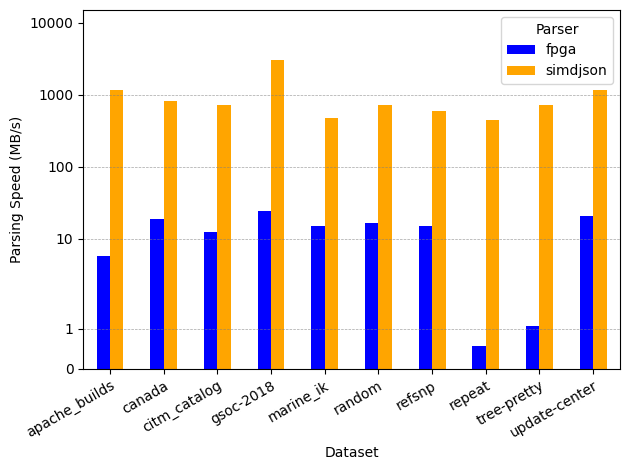

parser,fpga,simdjson
dataset,,
apache_builds,5.684580,1161.069006
canada,18.605186,813.443269
citm_catalog,12.398813,723.764836
gsoc-2018,24.285550,3041.850425
marine_ik,14.991225,475.656714
random,16.296592,728.546800
refsnp,14.703118,583.345418
repeat,0.579117,447.710316
tree-pretty,1.081803,714.060911


In [71]:
from matplotlib import ticker

df = df_backup.copy()
df = df[df['source'] == 'trimmed']
df = df[df['workload'] == 'string_lengths']
#df = df[df['parser'] == 'simdjson']

# Define colors for the two parsers
colors = ['blue', 'orange']

# Group data by "dataset" and calculate average bandwidth for each parser
grouped_data = df.groupby(['dataset', 'parser'])['bandwidth'].mean().unstack()

# Create the bar chart with log scale y-axis
fig, ax = plt.subplots()  # Create figure and axis objects
grouped_data.plot(kind='bar', color=colors, ax=ax)

# Set logarithmic scale for y-axis
ax.set_yscale('symlog')  # Set y-axis to logarithmic scale
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%d"))

y_ticks = ax.get_yticks()  # Get existing y-axis tick values

# Iterate through ticks and plot lines (adjust color and style as needed)
for tick in y_ticks:
    if tick != 0:  # Skip the zero line (optional)
        plt.axhline(y=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
        
# Customize the plot
plt.xlabel('Dataset')
plt.ylabel('Parsing Speed (MB/s)')
plt.legend(title='Parser', loc='upper right')
plt.ylim(0, 15000)
#plt.subplots_adjust(top=1.1)
plt.xticks(rotation=30, ha='right', rotation_mode='anchor')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()
grouped_data

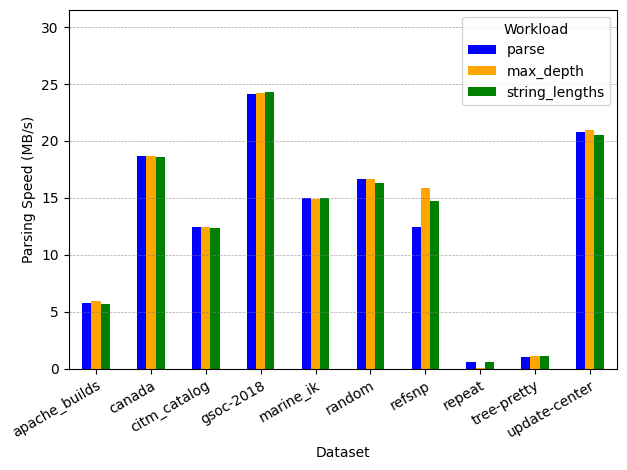

In [50]:
df = df_backup.copy()

df = df[df['source'] == 'trimmed']
df = df[df['parser'] == 'fpga']

# Define colors for the two parsers
colors = ['blue', 'orange', 'green']

# Group data by "dataset" and calculate average bandwidth for each parser
grouped_data = df.groupby(['dataset', 'workload'])['bandwidth'].mean().unstack()
workload_order = ['parse', 'max_depth', 'string_lengths']
grouped_data = grouped_data[workload_order]

# Create the bar chart with log scale y-axis
fig, ax = plt.subplots()  # Create figure and axis objects
grouped_data.plot(kind='bar', color=colors, ax=ax)

# Set logarithmic scale for y-axis
#ax.set_yscale('log')  # Set y-axis to logarithmic scale

y_ticks = ax.get_yticks()  # Get existing y-axis tick values

# Iterate through ticks and plot lines (adjust color and style as needed)
for tick in y_ticks:
    if tick != 0:  # Skip the zero line (optional)
        plt.axhline(y=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Customize the plot
plt.xlabel('Dataset')
plt.ylabel('Parsing Speed (MB/s)')
#plt.title('Bandwidth Comparison by Parser (Logarithmic Y-Axis)')
plt.legend(title='Workload', loc='upper right')
plt.xticks(rotation=30, ha='right', rotation_mode='anchor')  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()